# Inferring Measurement Error of ∆F From Wild-Type Measurements

© 2018 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 

In [1]:
import sys
sys.path.insert(0, '../../')
import numpy as np
import pandas as pd
import mut.viz
import mut.thermo
import mut.stats
import mut.bayes
import matplotlib.pyplot as plt
import tqdm 
import seaborn as sns
mut.viz.plotting_style()
colors = mut.viz.color_selector('mut')
pboc = mut.viz.color_selector('pboc')
constants = mut.thermo.load_constants()

In [2]:
# Load the induction paper data
data = pd.read_csv('../../data/csv/RazoMejia2018_data.csv')
data['repressors'] *= 2
data.rename(columns={'fold_change_A':'fold_change',
                    'IPTG_uM':'IPTGuM'}, inplace=True)
data = data[data['repressors'] > 0].copy()

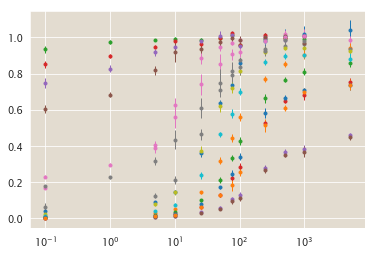

In [3]:
# repressor_colors = 
for g, d in data.groupby(['operator', 'repressors']):
    _d = d.groupby(['IPTGuM']).agg(('mean', 'sem')).reset_index()
    plt.errorbar(_d['IPTGuM'], _d['fold_change']['mean'], _d['fold_change']['sem'],
                 lw=1, capsize=0, linestyle='none',fmt='.')
plt.xscale('log')


In [27]:
# Compute the reference bohr for each measurement. 
ref_bohr = -mut.thermo.SimpleRepression(R=data['repressors'], ep_r=data['binding_energy'],
                                      ka=constants['Ka'], ki=constants['Ki'], 
                                      ep_ai=constants['ep_AI'], effector_conc=data['IPTGuM']).bohr_parameter()
data['ref_bohr'] = ref_bohr

In [38]:
# Load the stan model. 
model = mut.bayes.StanModel('../stan/empirical_F.stan', force_compile=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_02e2041d093f59ee2ded9e2d0290dd23 NOW.


Precompiled model not found. Compiling model...


/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmpmxg84_45/stanfit4anon_model_02e2041d093f59ee2ded9e2d0290dd23_1491360954962193016.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


finished!


In [41]:
# Loop through each unique repressor, operator, and IPTG and calculate the ∆F. 
dbohr_stats = []
for g, d in tqdm.tqdm(data.groupby(['repressors', 'operator', 'IPTGuM'])):
    data_dict = {'N':len(d), 'ref_bohr':d['ref_bohr'].values[0],
                'foldchange':d['fold_change']}
    fit, samples = model.sample(data_dict, iter=5000, control=dict(adapt_delta=0.9))
    
    # Compute the stats. 
    stats = mut.stats.compute_statistics(samples, varnames=['fc_mu', 'empirical_bohr'],
                                        logprob_name='lp__')
    stats['ref_bohr'] = d['ref_bohr'].values[0]
    stats['repressors'] = g[0]
    stats['operator'] = g[1]
    stats['IPTGuM'] = g[2]    
    dbohr_stats.append(stats)
dbohr = pd.concat(dbohr_stats)

100%|██████████| 216/216 [01:45<00:00,  1.93it/s]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log
  if sys.path[0] == '':


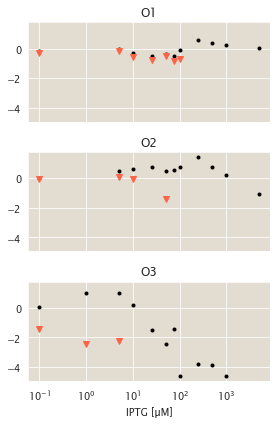

In [92]:
fig, ax = plt.subplots(3, 1, figsize=(4, 6), sharex=True, sharey=True)
axes = {'O1':ax[0], 'O2':ax[1], 'O3':ax[2]}
for g, d in dbohr.groupby(['operator', 'repressors']):
    _ax = axes[g[0]]
    if g[1] == 22:
        # Compute the error function. 
        fc = d[d['parameter']=='fc_mu']
        bohr = d[d['parameter']=='empirical_bohr']
        upper = np.abs(fc['hpd_max'] - fc['median'])
        lower = np.abs(fc['hpd_min'] - fc['median'])
        mu = fc['median']
        df_max = np.log((1 - (1 / ((mu/upper) - 1)) * (1 / (1 - mu))))
        df_min = np.log((1 + (1 / ((mu/upper) + 1)) * (1 / (1 - mu))))
        delta_bohr = bohr['ref_bohr'] - bohr['median']
        _ax.plot(bohr['IPTGuM'], delta_bohr, 'k.')
        _ax.plot(bohr['IPTGuM'], delta_bohr.values + (df_max), 'v', color='tomato')
#         _ax.vlines(d['IPTGuM'], d['hpd_min'], d['hpd_max'], color='k')
#         _ax.vlines(d['IPTGuM'], d['min_corr'], d['max_corr'], color='orange')

   
titles = ['O1', 'O2', 'O3']
for i, a in enumerate(ax):
    a.set_xscale('log')
    a.set_title(titles[i])
#     a.set_ylim([-10, 3])
ax[-1].set_xlabel('IPTG [µM]')
    
plt.tight_layout()

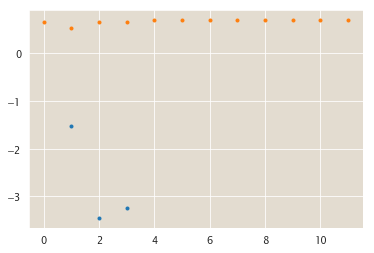

In [86]:
plt.plot(np.arange(12), df_max,'.')
plt.plot(np.arange(12), df_min,'.')

In [84]:
df_min

0    -2.767528
0    -1.225886
0    -2.566545
0    -2.758123
0    -6.787416
0   -14.136701
0    -8.253002
0    -8.740870
0   -12.265255
0    -7.090245
0    -7.276313
0    -5.676197
dtype: float64

In [ ]:
plt.plot(samples['fc_mu'], samples['fc_sigma'], ',')
plt.xlim([0, 1])


In [ ]:
plt.plot(samples['empirical_bohr'], np.log((1/samples['fc_sigma']) - 1), '.')

In [ ]:
dbohr